In [ ]:
 !pip install kaggle

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

In [ ]:
 from google.colab import files

 uploaded = files.upload()

 for fn in uploaded.keys():
   print('User uploaded file "{name}" with length {length} bytes'.format(
       name=fn, length=len(uploaded[fn])))

 # Then move kaggle.json into the folder where the API expects to find it.
 !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
User uploaded file "kaggle (1).json" with length 63 bytes


In [ ]:
 !kaggle datasets download -d techsash/waste-classification-data

 99% 425M/427M [00:16<00:00, 31.3MB/s]
100% 427M/427M [00:17<00:00, 26.3MB/s]


In [ ]:
 !unzip waste-classification-data.zip

## Data Processing

In [ ]:
train_dir = '/content/DATASET/TRAIN'
test_dir = '/content/DATASET/TEST'

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize((256)),
    transforms.ToTensor(),
    transforms.CenterCrop(224),
    transforms.Normalize(
           mean=[0.485, 0.456, 0.406],
           std=[0.229, 0.224, 0.225])
])

In [ ]:
trainset = datasets.ImageFolder(train_dir, transform=transform)
testset = datasets.ImageFolder(test_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [ ]:
# length of the training and test datasets
print(f"Length of the training dataset: {len(trainset)}")
print(f"Length of the test dataset: {len(testset)}")

Length of the training dataset: 22564
Length of the test dataset: 2513


In [ ]:
# label counts
import pandas as pd

# Training data
train_labels = [label for _, label in trainset]
train_labels = pd.Series(train_labels)
print("Training label counts:")
print(train_labels.value_counts())

# Test data
test_labels = [label for _, label in testset]
test_labels = pd.Series(test_labels)
print("Test label counts:")
print(test_labels.value_counts())

Training label counts:
0    12565
1     9999
Name: count, dtype: int64
Test label counts:
0    1401
1    1112
Name: count, dtype: int64


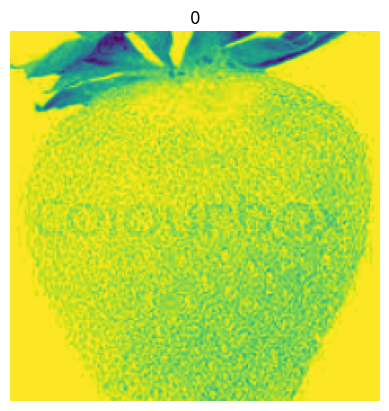

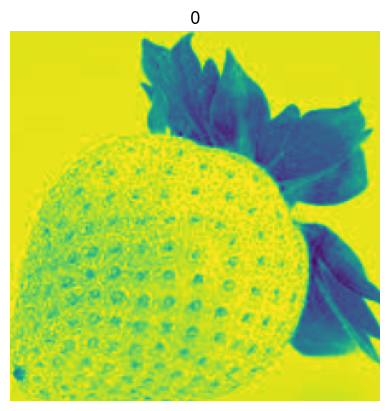

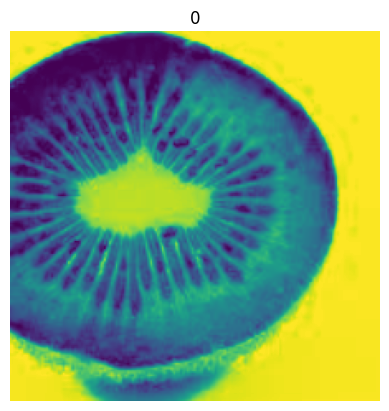

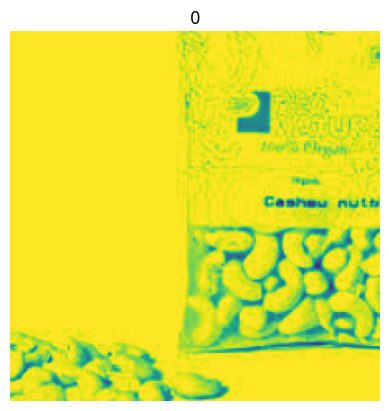

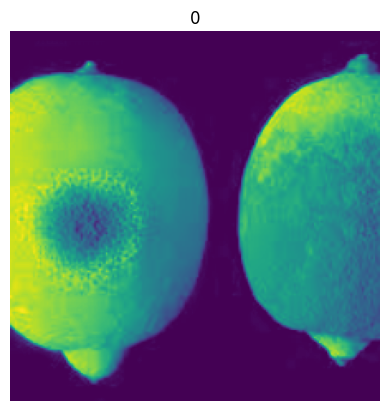

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(5):
    image, label = trainset[i]
    image = image[0].squeeze()
    # plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)
    plt.show()

In [ ]:
image, label = trainset[0]
image.shape

torch.Size([3, 224, 224])

In [ ]:
image[0,:]

tensor([[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
        [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
        [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
        ...,
        [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
        [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
        [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]])

## Helper Function

In [ ]:
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import torch.nn.functional as F

# Set the random seed for reproducibility
torch.manual_seed(12345)

# Function to calculate the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to track gradients
        for data, target in loader:
            # check if cuda is available
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            output = model(data)  # Forward pass
            _, predicted = torch.max(output.data, 1)  # Get the predicted classes
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Define a function for training.
def train_model(model, loss_func, num_epochs, optimizer, train_loader, val_loader):

  train_loss_log = []
  train_acc_log = []
  test_acc_log = []

  # Move model to GPU if CUDA is available
  if torch.cuda.is_available():
      model = model.cuda()
  tic = time.time()
  for epoch in range(1,num_epochs+1):
    train_loss = 0
    for i, data in enumerate(train_loader):
      x, y = data
      # check if cuda is available
      if torch.cuda.is_available():
        x, y = x.cuda(), y.cuda()
      # get predicted y value from our current model
      pred_y = model(x)
      # calculate the loss
      loss = loss_func(pred_y,y)
      # Zero the gradient of the optimizer
      optimizer.zero_grad()
      # Backward pass: Compute gradient of the loss with respect to model parameters
      loss.backward()
      # update weights
      optimizer.step()
      train_loss += loss.item() * len(x)
    # change the model to evaluation mode to calculate the test loss; We will come back to this later after learning Dropout and Batch Normalization
    train_loss/=len(train_loader)
    train_loss_log.append(train_loss)
    train_acc = calculate_accuracy(train_loader, model)
    val_acc = calculate_accuracy(val_loader, model)
    train_acc_log.append(train_acc)
    test_acc_log.append(val_acc)
    print("Epoch {:2},  Training Loss: {:9.4f}, Training Accuracy: {:9.2f},  Val Accuracy: {:7.2f}".format(epoch, train_loss, train_acc, val_acc))
  toc = time.time()
  print("Elapsed Time : {:7.2f}".format(toc-tic))
  return train_loss_log, train_acc_log, test_acc_log

## Multilayer Perceptron - Three Hidden Layer

In [ ]:
# build three hidden layer fully connected net here
class ThreeHiddenLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(ThreeHiddenLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.fc4 = nn.Linear(hidden_dims[2], output_dim)

    def forward(self, x):
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
# build the model
input_dim = 3*224*224
hidden_dims = [256, 128, 64]
output_dim = 10
epochs = 10
learning_rate = 1e-3
three_hidden_nn = ThreeHiddenLayerNN(input_dim, hidden_dims, output_dim)

# define the loss function and the optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(three_hidden_nn.parameters(), lr=learning_rate)

train_loss_log, train_acc_log, test_acc_log = train_model(three_hidden_nn, loss_func, epochs, optimizer, trainloader, testloader)

Epoch  1,  Training Loss:   53.2937, Training Accuracy:     81.36,  Val Accuracy:   84.32
Epoch  2,  Training Loss:   29.9314, Training Accuracy:     82.48,  Val Accuracy:   86.55
Epoch  3,  Training Loss:   27.4286, Training Accuracy:     83.21,  Val Accuracy:   83.88
Epoch  4,  Training Loss:   26.5467, Training Accuracy:     83.04,  Val Accuracy:   85.12
Epoch  5,  Training Loss:   24.8895, Training Accuracy:     84.49,  Val Accuracy:   85.12
Epoch  6,  Training Loss:   24.1176, Training Accuracy:     85.56,  Val Accuracy:   85.48
Epoch  7,  Training Loss:   22.9704, Training Accuracy:     86.13,  Val Accuracy:   84.12
Epoch  8,  Training Loss:   22.2376, Training Accuracy:     87.21,  Val Accuracy:   85.99
Epoch  9,  Training Loss:   20.4626, Training Accuracy:     85.48,  Val Accuracy:   80.98
Epoch 10,  Training Loss:   19.6119, Training Accuracy:     87.36,  Val Accuracy:   85.04
Elapsed Time : 4904.43


In [ ]:
# Test accuracy of the model
three_hidden_nn_acc = calculate_accuracy(testloader, three_hidden_nn)
three_hidden_nn_acc

85.03780342220453

In [ ]:
# Compute the number of parameters
num_params_three_hidden_nn = count_parameters(three_hidden_nn)
num_params_three_hidden_nn

38577226

## Vision Transformer (ViT)

In [ ]:
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Set the random seed for reproducibility
torch.manual_seed(12345)

# Function to calculate the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to track gradients
        for data, target in loader:
            # check if cuda is available
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            output = model(data)  # Forward pass
            _, predicted = torch.max(output.data, 1)  # Get the predicted classes
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [ ]:
# Define a function for training.
def train_model(model, loss_func, num_epochs, optimizer, train_loader, val_loader):

  train_loss_log = []
  train_acc_log = []
  test_acc_log = []

  # Move model to GPU if CUDA is available
  if torch.cuda.is_available():
      model = model.cuda()
  tic = time.time()
  for epoch in range(1,num_epochs+1):
    train_loss = 0
    for i, data in enumerate(train_loader):
      x, y = data
      # check if cuda is available
      if torch.cuda.is_available():
        x, y = x.cuda(), y.cuda()
      # get predicted y value from our current model
      pred_y = model(x)
      # calculate the loss
      loss = loss_func(pred_y,y)
      # Zero the gradient of the optimizer
      optimizer.zero_grad()
      # Backward pass: Compute gradient of the loss with respect to model parameters
      loss.backward()
      # update weights
      optimizer.step()
      train_loss += loss.item() * len(x)
    # change the model to evaluation mode to calculate the test loss; We will come back to this later after learning Dropout and Batch Normalization
    train_loss/=len(train_loader)
    train_loss_log.append(train_loss)
    train_acc = calculate_accuracy(train_loader, model)
    val_acc = calculate_accuracy(val_loader, model)
    train_acc_log.append(train_acc)
    test_acc_log.append(val_acc)
    print("Epoch {:2},  Training Loss: {:9.4f}, Training Accuracy: {:9.2f},  Val Accuracy: {:7.2f}".format(epoch, train_loss, train_acc, val_acc))
  toc = time.time()
  print("Elapsed Time : {:7.2f}".format(toc-tic))
  return train_loss_log, train_acc_log, test_acc_log

# Load the pre-trained ViT model
model = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)

# Modify the last layer for waste classification
num_classes = 10
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 61.8MB/s]


In [ ]:
import torch
from torch.utils.data import SubsetRandomSampler

# Define the fraction of data you want to use
fraction = 0.1

# Calculate the number of samples to keep
num_samples = int(len(trainset) * fraction)

# Create indices to sample from
indices = torch.randperm(len(trainset))

# Take the first num_samples indices
subset_indices = indices[:num_samples]

# Create a sampler using the subset indices
subset_sampler = SubsetRandomSampler(subset_indices)
subset_loader = DataLoader(trainset, batch_size=64, sampler=subset_sampler)

In [ ]:
# Define the loss function and the optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 5
train_loss_log, train_acc_log, test_acc_log = train_model(model, loss_func, epochs, optimizer, subset_loader, testloader)

Epoch  1,  Training Loss:   19.6232, Training Accuracy:     95.79,  Val Accuracy:   87.31
Epoch  2,  Training Loss:    7.0906, Training Accuracy:     99.16,  Val Accuracy:   92.92
Epoch  3,  Training Loss:    2.7539, Training Accuracy:     99.34,  Val Accuracy:   88.42
Epoch  4,  Training Loss:    2.1708, Training Accuracy:    100.00,  Val Accuracy:   90.37
Epoch  5,  Training Loss:    0.3346, Training Accuracy:    100.00,  Val Accuracy:   90.45
Elapsed Time : 9591.21


In [ ]:
# Test accuracy of the model
vit_acc = calculate_accuracy(testloader, model)
print("ViT Accuracy: {:.2f}%".format(vit_acc))

# Compute the number of parameters
num_params_vit = count_parameters(model)
print("Number of parameters in ViT: ", num_params_vit)

ViT Accuracy: 90.45%
Number of parameters in ViT:  85806346


In [ ]:
import torch
def predict_and_collect_labels(loader, model):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    with torch.no_grad():  # No need to track gradients
        for data, target in loader:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            output = model(data)  # Forward pass
            _, predicted = torch.max(output.data, 1)  # Get the predicted classes
            y_true.extend(target.cpu().numpy())  # Collect true labels
            y_pred.extend(predicted.cpu().numpy())  # Collect predicted labels
    return y_true, y_pred

In [ ]:
y_true, y_pred = predict_and_collect_labels(testloader, model)

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_true, y_pred, average='binary')
print("F1 Score:", f1)

F1 Score: 0.8811881188118812
